In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba


## Hard disks in a square
Consider a system of $N$ identical hard disks with diameter $1$ in a
square of size $10$. The use of periodic boundary conditions can be
switched on or off. The
energy of this system ($U$) is either $U=0$ (no overlaps) or
$U=\infty$ (at least one overlap). We would like to calculate the
radial distribution function of the disks ($g\left(r\right), \,\,r <
5$) in the canonical ensemble. There are 2 methods of calculating
this:
### 1. Dynamic scheme
The disks are initially placed on a lattice
and trial moves are performed to translate the disks. A trial move is
accepted when there are no overlaps and rejected when there are one or
more overlaps.
<div style="max-width:300px;margin-right: auto; margin-right: 0;">

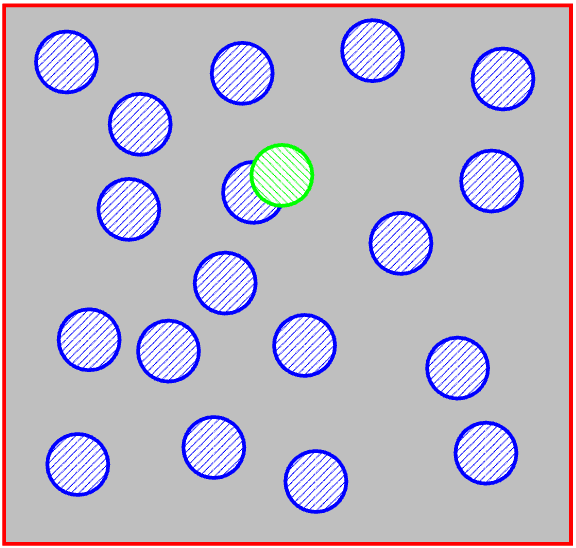
</div>


### 2. Static scheme
In every cycle, all disks are put at a
completely random position in the system. The radial distribution
function of this configuration is calculated and multiplied by the
Boltzmann factor of the system ($0$ when there is at least one overlap
and $1$ when there are no overlaps).
<div style="max-width:300px;margin-right: auto; margin-right: 0;">

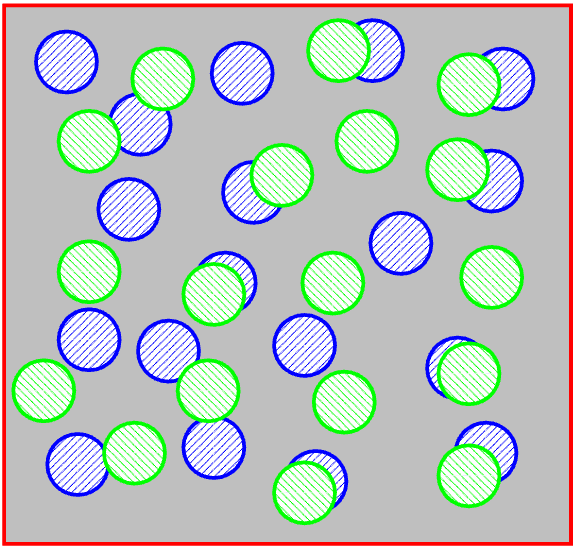
</div>

**Figures:** Eighteen hard disks in a box. The blue particles constitute the old system,
 the green particles the new system. The dynamic scheme performs a displacement trial move
 in one of the particles. The move is rejected when there is a overlap. The static scheme puts all
 particles at new random positions in the system. The move is accepted when there is no overlap.

### Question 1:
Write a program to calculate $g\left(r\right)$. Once the radial distribution function is implemented, it can be used for both methods. 
Make sure that both methods give the same result when $N$ is small. 

In [2]:
@numba.njit
def lowerTriangularDistMatrix(positions: np.ndarray, numberOfParticles: int, boxSize: float):
    dist = np.zeros(int(0.5 * numberOfParticles * (numberOfParticles - 1)))
    counter = 0
    for i in range(numberOfParticles - 1):
        for j in range(i + 1, numberOfParticles):
            dr = positions[i] - positions[j]
            dr = (dr + 0.5 * boxSize) % boxSize - 0.5 * boxSize
            dist[counter] = np.sqrt(np.sum(dr**2))
            counter += 1
    return dist

@numba.njit
def checkOverlap(newPosition: float, positions: np.ndarray, boxSize: float, particleIdx: int):
    dr = newPosition - positions
    dr = (dr + 0.5 * boxSize) % boxSize - 0.5 * boxSize
    d = np.sqrt(np.sum(dr**2, axis=-1))
    d[particleIdx] = np.inf

    # exclude 0, because that is the same particle
    return np.any(d < 1.0)

@numba.njit
def dynamicHardDisks(
        numberOfInitCycles: int, 
        numberOfProdCycles: int, 
        numberOfParticles: int, 
        maxDisplacement: float, 
        sampleFrequency: int,
        boxSize: float,
        rdfBins: int, 
    ):
    
    
    latticeSites = int(boxSize)
    nLattice = latticeSites**2
    positions = np.zeros((nLattice, 2))
    
    count = 0
    for x in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
        for y in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
            positions[count] = np.array([x,y])
            count += 1
    positions = positions[np.random.choice(nLattice, nLattice, replace=False)[:numberOfParticles]]

    numberOfSamples = numberOfProdCycles // sampleFrequency
    samplePositions = np.zeros((numberOfSamples, numberOfParticles, 2))
    sampleParticleIdx = np.zeros((numberOfSamples,2))
    sampleCounter = 0

    rdf = np.zeros(rdfBins)
    
    numberOfAttemptedMoves = 0
    numberOfAcceptedMoves = 0
    
    for cycle in range(numberOfInitCycles + numberOfProdCycles):
        numberOfAttemptedMoves += 1
        displacement = (np.random.rand(2) - 0.5) * maxDisplacement
        particleIdx = np.random.choice(numberOfParticles)
        sampleParticleIdx[sampleCounter,0] = particleIdx
        newPosition = positions[particleIdx] + displacement
        
        overlap = checkOverlap(newPosition, positions, boxSize, particleIdx)
        if not overlap:
            positions[particleIdx] = newPosition
            numberOfAcceptedMoves += 1
                
        if cycle >= numberOfInitCycles and cycle % sampleFrequency == 0:
            samplePositions[sampleCounter] = positions
            sampleParticleIdx[sampleCounter,1] = not overlap
            sampleCounter += 1

            dist = lowerTriangularDistMatrix(positions, numberOfParticles, boxSize)
            hist, edges = np.histogram(dist, bins=rdfBins, range=(0, 0.5 * boxSize))
            rdf += 2 * hist

    areaNorm = np.pi * (edges[1:]**2 - edges[:-1]**2)
    r2 = numberOfParticles * (numberOfParticles - 1) * areaNorm
    rdf *= boxSize**2 / (r2 * sampleCounter)
    print(numberOfAcceptedMoves/numberOfAttemptedMoves)
    return samplePositions % boxSize, rdf, sampleParticleIdx



@numba.njit
def staticHardDisks(
        numberOfInitCycles: int, 
        numberOfProdCycles: int, 
        numberOfParticles: int, 
        maxDisplacement: float, 
        sampleFrequency: int,
        boxSize: float,
        rdfBins: int, 
    ):
    
    latticeSites = int(boxSize)
    nLattice = latticeSites**2
    positions = np.zeros((nLattice, 2))
    
    count = 0
    for x in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
        for y in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
            positions[count] = np.array([x,y])
            count += 1
    positions = positions[np.random.choice(nLattice, nLattice, replace=False)[:numberOfParticles]]

    numberOfSamples = numberOfProdCycles // sampleFrequency
    samplePositions = np.zeros((numberOfSamples, numberOfParticles, 2))
    sampleCounter = 0

    rdf = np.zeros(rdfBins)
    
    numberOfAttemptedMoves = 0
    numberOfAcceptedMoves = 0

    for cycle in range(numberOfInitCycles + numberOfProdCycles):
        numberOfAttemptedMoves += 1
        
        newPositions = np.random.rand(numberOfParticles, 2) * boxSize

        overlap = False
        for i in range(numberOfParticles - 1):
            for j in range(i + 1, numberOfParticles):
                r2 = np.sum((newPositions[i] - newPositions[j])**2, axis=-1)
                if (r2 < 1.0):
                    overlap = True
                    break
            if overlap:
                break
        
        if not overlap:
            positions = newPositions
            numberOfAcceptedMoves += 1

        if cycle >= numberOfInitCycles and cycle % sampleFrequency == 0:
            samplePositions[sampleCounter] = positions
            sampleCounter += 1

            dist = lowerTriangularDistMatrix(positions, numberOfParticles, boxSize)
            hist, edges = np.histogram(dist, bins=rdfBins, range=(0, 0.5 * boxSize))
            rdf += 2 * hist

    areaNorm = np.pi * (edges[1:]**2 - edges[:-1]**2)
    r2 = numberOfParticles * (numberOfParticles - 1) * areaNorm
    rdf *= boxSize**2 / (r2 * sampleCounter)
    print(numberOfAcceptedMoves/numberOfAttemptedMoves)
    return samplePositions % boxSize, rdf


In [3]:
boxSize = 20.0
x, rdf, pIdx = dynamicHardDisks(
    numberOfInitCycles = int(1e6), 
    numberOfProdCycles = int(1e2), 
    numberOfParticles = 64, 
    maxDisplacement = 2.0, 
    sampleFrequency = 1,
    boxSize = boxSize,
    rdfBins = 100
)

0.7544585541445855


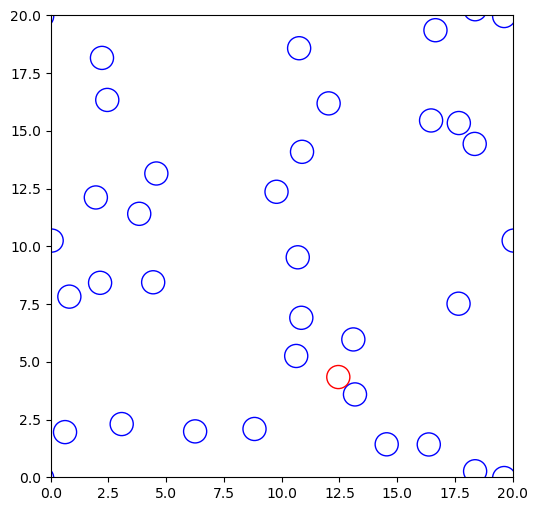

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

n_frames = np.shape(x)[0]
n_particles = np.shape(x)[1]
# Function to compute periodic offsets
def get_periodic_offsets(boxSize):
    return [
        np.array([0, 0]),            # Original position
        np.array([boxSize, 0]),     # Right
        np.array([-boxSize, 0]),    # Left
        np.array([0, boxSize]),     # Up
        np.array([0, -boxSize]),    # Down
        np.array([boxSize, boxSize]),       # Top-right
        np.array([-boxSize, boxSize]),      # Top-left
        np.array([boxSize, -boxSize]),      # Bottom-right
        np.array([-boxSize, -boxSize]),     # Bottom-left
    ]

# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, boxSize)
ax.set_ylim(0, boxSize)
ax.set_aspect('equal')

# Pre-compute offsets for periodic images
offsets = get_periodic_offsets(boxSize)
n_offsets = len(offsets)
# Pre-create all Circle objects
circle_patches = []
for _ in range(n_particles * n_offsets):  # Total number of circles
    circle = Circle((0, 0), 0.5, edgecolor="blue", fill=False)
    circle_patches.append(circle)
    ax.add_patch(circle)

# Update function for the animation
dynamic = True
def update(frame):
    positions = x[frame] % boxSize  # Get positions for the current frame
    modifiedIdx = [int(pIdx[frame,0]) * len(offsets) + i for i in range(len(offsets))]
    index = 0
    for position in positions:
        for offset in offsets:
            circle_patches[index].center = position + offset
            if dynamic:
                if index in modifiedIdx:
                    circle_patches[index].set_edgecolor("red")
                    if pIdx[frame,1]:
                        circle_patches[index].set_fill(True)
                else: 
                    circle_patches[index].set_edgecolor("blue")
                    circle_patches[index].set_fill(False)

            index += 1

# Create the animation
ani = FuncAnimation(fig, update, frames=n_frames, repeat=True)

# Display the animation inline in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


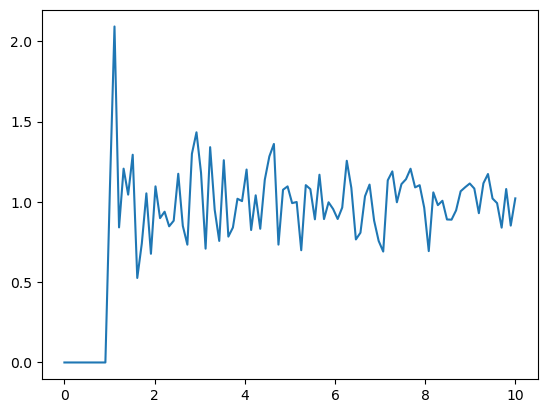

In [5]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0.0, 0.5 * boxSize, 100), rdf)

In [6]:
boxSize = 20.0
x, rdf = staticHardDisks(
    numberOfInitCycles = int(1e6), 
    numberOfProdCycles = int(1e5), 
    numberOfParticles = 32, 
    maxDisplacement = 0.2, 
    sampleFrequency = 5000,
    boxSize = boxSize,
    rdfBins = 100
)

0.020063636363636363


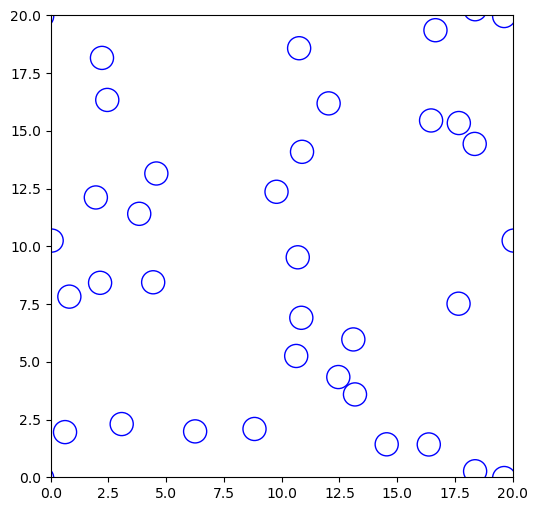

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

n_frames = np.shape(x)[0]
n_particles = np.shape(x)[1]

# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, boxSize)
ax.set_ylim(0, boxSize)
ax.set_aspect('equal')
# Pre-compute offsets for periodic images
offsets = get_periodic_offsets(boxSize)
n_offsets = len(offsets)

# Pre-create all Circle objects
circle_patches = []
for _ in range(n_particles * n_offsets):  # Total number of circles
    circle = Circle((0, 0), 0.5, edgecolor="blue", fill=False)
    circle_patches.append(circle)
    ax.add_patch(circle)
# Create the animation
dynamic = False
ani = FuncAnimation(fig, update, frames=n_frames, repeat=True)

# Display the animation inline in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


(0.0, 20.0)

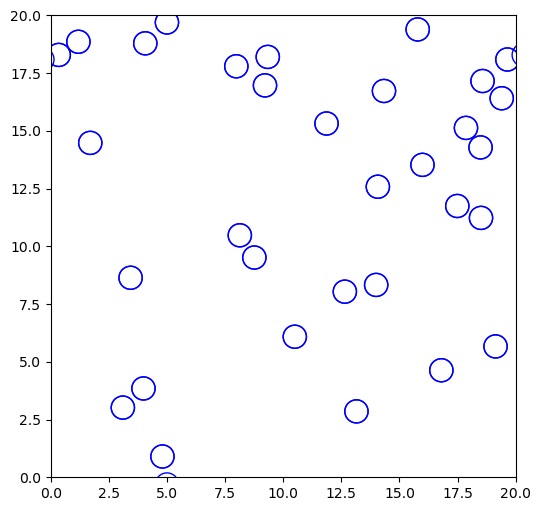

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
#ax.scatter(*x[-1].T % boxSize, s=1200)
plusX = np.array([boxSize, 0])
plusY = np.array([0, boxSize])

for pos in x[-1]:
    ax.add_patch(plt.Circle(pos, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos + plusX, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos - plusX, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos + plusY, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos - plusY, 0.5, edgecolor="blue", fill=False))
ax.set_xlim(0, boxSize)
ax.set_ylim(0, boxSize)